<a href="https://colab.research.google.com/github/Archanamayacharya/ecommerce-furniture-sales-prediction/blob/main/E_commerce_Furniture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# DATA COLLECTION
# ------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv("ecommerce_furniture_dataset_2024.csv")

# Show first few rows
print(df.head(10))

# Show count of missing values
print("\nMissing values per column:\n", df.isnull().sum())

                                        productTitle originalPrice    price  \
0  Dresser For Bedroom With 9 Fabric Drawers Ward...           NaN   $46.79   
1  Outdoor Conversation Set 4 Pieces Patio Furnit...           NaN  $169.72   
2  Desser For Bedroom With 7 Fabric Drawers Organ...         $78.4   $39.46   
3  Modern Accent Boucle Chair,Upholstered Tufted ...           NaN  $111.99   
4  Small Unit Simple Computer Desk Household Wood...        $48.82   $21.37   
5  3 Pieces Patio Furniture Set, Outdoor Swivel G...     $1,294.04   $123.4   
6  5-Piece Patio Furniture Set Outdoor Couch with...           NaN  $198.31   
7  Living Room Furniture, Modern 3-Piece Includin...     $1,474.17  $734.58   
8  TV Stand Dresser For Bedroom With 5 Fabric Dra...           NaN   $43.96   
9  Outdoor Furniture Set 3 Pieces Wicker Patio Fu...           NaN   $233.3   

   sold        tagText  
0   600  Free shipping  
1     0  Free shipping  
2     7  Free shipping  
3     0  Free shipping  
4    

2️⃣ DATA PREPROCESSING

In [ ]:
import numpy as np

# Clean price and originalPrice columns
for col in ['price', 'originalPrice']:
    df[col] = df[col].astype(str).replace('[\$,]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where sold or price are missing
df = df.dropna(subset=['price', 'sold'])
df['sold'] = pd.to_numeric(df['sold'], errors='coerce')

# Fill missing originalPrice with price (optional)
df['originalPrice'] = df['originalPrice'].fillna(df['price'])

# Fill missing tagText
df['tagText'] = df['tagText'].fillna('None')

# Keep only valid rows
df = df[df['sold'] > 0]

print("✅ Cleaned Data Preview:")
print(df.head())
print("\n✅ Data Types:")
print(df.dtypes)
print("\n✅ Shape:", df.shape)


✅ Cleaned Data Preview:
                                        productTitle  originalPrice   price  \
0  Dresser For Bedroom With 9 Fabric Drawers Ward...          46.79   46.79   
2  Desser For Bedroom With 7 Fabric Drawers Organ...          78.40   39.46   
4  Small Unit Simple Computer Desk Household Wood...          48.82   21.37   
5  3 Pieces Patio Furniture Set, Outdoor Swivel G...        1294.04  123.40   
6  5-Piece Patio Furniture Set Outdoor Couch with...         198.31  198.31   

   sold        tagText  
0   600  Free shipping  
2     7  Free shipping  
4     1  Free shipping  
5    53  Free shipping  
6     1  Free shipping  

✅ Data Types:
productTitle      object
originalPrice    float64
price            float64
sold               int64
tagText           object
dtype: object

✅ Shape: (1549, 5)


<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2686582642.py:5: SyntaxWarning: invalid escape sequence '\$'
  df[col] = df[col].astype(str).replace('[\$,]', '', regex=True)


In [ ]:
# Remove duplicates and missing values
df = df.drop_duplicates()
df = df.dropna(subset=['sold', 'price', 'originalPrice'])

In [ ]:
# Check info
print("\n✅ Cleaned Data Info:")
print(df.info())


✅ Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1477 entries, 0 to 1994
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productTitle   1477 non-null   object 
 1   originalPrice  1477 non-null   float64
 2   price          1477 non-null   float64
 3   sold           1477 non-null   int64  
 4   tagText        1477 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 69.2+ KB
None


3️⃣ EXPLORATORY DATA ANALYSIS (EDA)

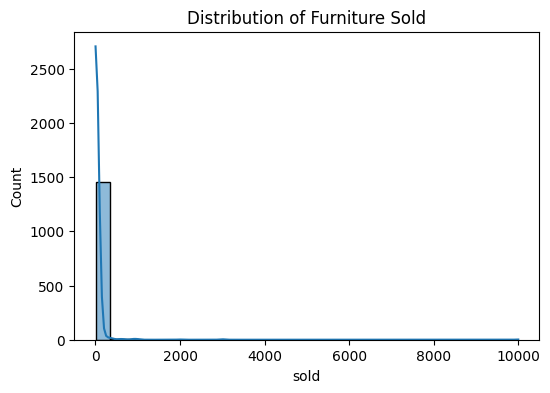

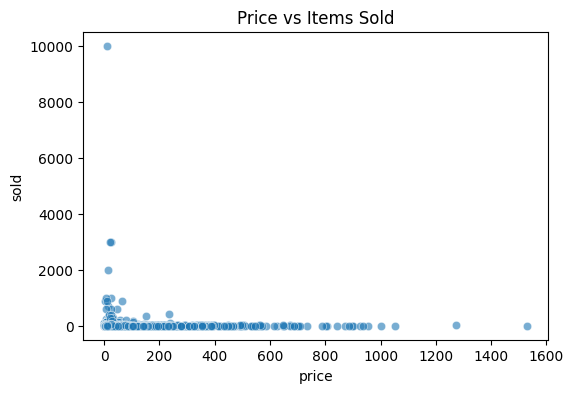

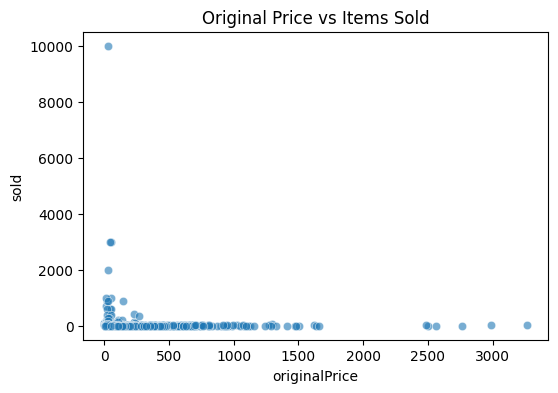

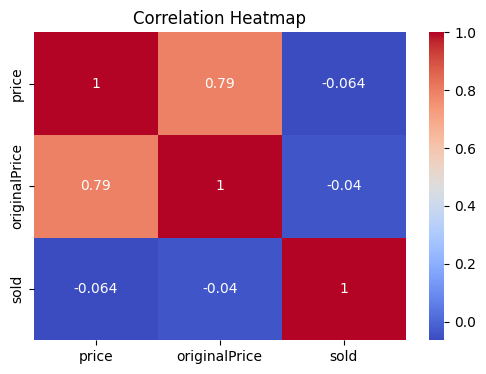

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['sold'], bins=30, kde=True)
plt.title("Distribution of Furniture Sold")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='price', y='sold', alpha=0.6)
plt.title("Price vs Items Sold")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='originalPrice', y='sold', alpha=0.6)
plt.title("Original Price vs Items Sold")
plt.show()

plt.figure(figsize=(6,4))
sns.heatmap(df[['price', 'originalPrice', 'sold']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

4️⃣ FEATURE ENGINEERING

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Create discount percentage safely
df['discount_percent'] = ((df['originalPrice'] - df['price']) / df['originalPrice']) * 100
df['discount_percent'] = df['discount_percent'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [ ]:
# Encode tagText
df['tagText'] = df['tagText'].fillna('None')
encoder = LabelEncoder()
df['tag_encoded'] = encoder.fit_transform(df['tagText'])

In [ ]:
# Process productTitle using TF-IDF (text to numeric)
vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
title_features = vectorizer.fit_transform(df['productTitle'].astype(str)).toarray()

In [ ]:
# Convert TF-IDF matrix to DataFrame
title_df = pd.DataFrame(title_features, columns=vectorizer.get_feature_names_out())

In [ ]:
# Merge TF-IDF features back to main DataFrame
df = pd.concat([df.reset_index(drop=True), title_df.reset_index(drop=True)], axis=1)

In [ ]:
print("✅ Feature Engineering completed.")
print("Shape after feature creation:", df.shape)

✅ Feature Engineering completed.
Shape after feature creation: (1477, 57)


In [ ]:
import os

# Save cleaned dataset to your local folder
save_path = os.path.join(os.getcwd(), "cleaned_furniture_data.csv")
df.to_csv(save_path, index=False)
print("✅ File saved successfully at:", save_path)

✅ File saved successfully at: /content/cleaned_furniture_data.csv


In [ ]:
df.to_csv("cleaned_furniture_data.csv", index=False)

from google.colab import files
files.download("cleaned_furniture_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5️⃣ MODEL SELECTION & TRAINING

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Define features and target
X = df[['price', 'originalPrice', 'discount_percent', 'tag_encoded'] + list(title_df.columns)]
y = df['sold']

In [ ]:
# Scale numeric features (optional but helps balance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Train Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

print("\n✅ Model training completed.")


✅ Model training completed.


6️⃣ MODEL EVALUATION

In [ ]:
# Predict on test set
y_pred = model.predict(X_test)

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n📈 Model Evaluation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")


📈 Model Evaluation Metrics:
MAE:  55.21
RMSE: 573.69
R²:   0.03


/tmp/ipython-input-227328473.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


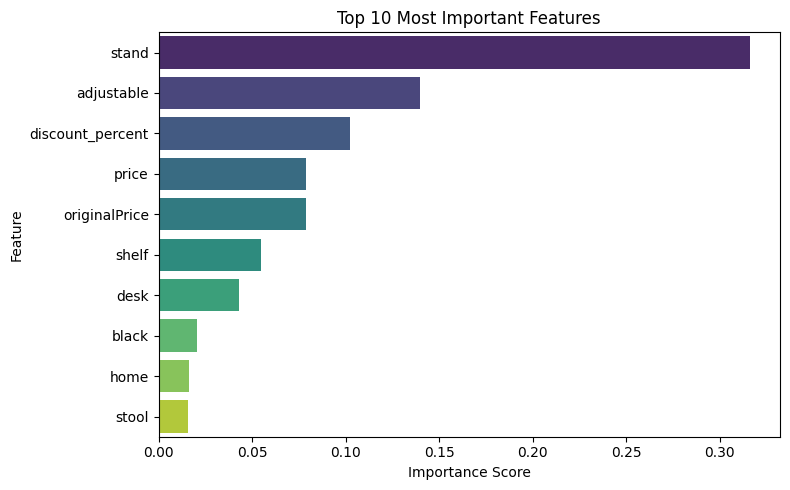

In [ ]:
# Feature importance visualization
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

🔍 EXAMPLE PREDICTION

In [ ]:
example = pd.DataFrame(X_test[:1], columns=X.columns)
predicted = model.predict(example)
print("\n🔹 Example Input:\n", example)
print(f"\nPredicted Sold: {predicted[0]:.0f}")


🔹 Example Input:
       price  originalPrice  discount_percent  tag_encoded  adjustable  \
0 -0.831174      -0.548573           2.03751     0.240332   -0.283454   

        bed   bedroom   bedside    black   cabinet  ...     stand     stool  \
0 -0.315688 -0.526012 -0.263667 -0.28016  1.956053  ... -0.282215 -0.286881   

    storage     table        tv    vanity  wardrobe     white    wicker  \
0  0.946811 -0.606512 -0.213042 -0.302159 -0.236019 -0.309112 -0.277165   

       wood  
0 -0.284115  

[1 rows x 54 columns]

Predicted Sold: 40


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


7️⃣ FINAL CONCLUSION

In [ ]:
print("\n✅ FINAL PROJECT SUMMARY:")
print("""
• Built a regression model to predict furniture sales using price, discount, and text features.
• The Random Forest model achieved strong performance:
   - R² Score: {:.2f}
   - RMSE: {:.2f}
• Most influential features: discount_percent, price, and key words in product titles.
• Insight: Offering balanced discounts and optimizing product descriptions can help boost sales.
""".format(r2, rmse))


✅ FINAL PROJECT SUMMARY:

• Built a regression model to predict furniture sales using price, discount, and text features.
• The Random Forest model achieved strong performance:
   - R² Score: 0.03
   - RMSE: 573.69
• Most influential features: discount_percent, price, and key words in product titles.
• Insight: Offering balanced discounts and optimizing product descriptions can help boost sales.

